### First Part
* Generate a simple dataset -> train/test
* Train and save model
* Load and save it
* Evaluate performance models
* PyTorch hybrid models  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import RealAmplitudes
# from qiskit_machine_learning.neural_networks.neural_network
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA,ADAM
from qiskit_algorithms.utils import algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn import gaussian_process
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

In [2]:
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier


from IPython.display import clear_output

algorithm_globals.random_seed = 42

#Cretae 2 sampler, first one for training second one for transfer

sampler_teach = Sampler()
sampler_transfer = Sampler()

#### Prepare Dataset
* 40 samples- each sample has 2 features -> `(40,2)`
* Labels are obtained by summing up features by columns and if the sum is more than `1` then this sample is labeles as `1` and `0` orherwise

In [3]:
num_samples = 40
num_features = 2

features = 2 * algorithm_globals.random.random([num_samples,num_features]) -1
labels = 1* (np.sum(features,axis=1) >=0 ) #in 0 and 1
features, labels

'''
# Number of data points
n = 1000

# Generate features
x1 = np.random.uniform(0, 10, n)  # Feature 1 (x1) between 0 and 10
x2 = np.random.uniform(0, 10, n)  # Feature 2 (x2) between 0 and 10

# Nonlinear function as the target for regression
y = np.sin(x1) + np.cos(x2)

# Create a Pandas DataFrame
df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'y': y
})

# Save to CSV
df.to_csv('qml_regression_dataset.csv', index=False)

# Show first few rows
df.head()
'''

"\n# Number of data points\nn = 1000\n\n# Generate features\nx1 = np.random.uniform(0, 10, n)  # Feature 1 (x1) between 0 and 10\nx2 = np.random.uniform(0, 10, n)  # Feature 2 (x2) between 0 and 10\n\n# Nonlinear function as the target for regression\ny = np.sin(x1) + np.cos(x2)\n\n# Create a Pandas DataFrame\ndf = pd.DataFrame({\n    'x1': x1,\n    'x2': x2,\n    'y': y\n})\n\n# Save to CSV\ndf.to_csv('qml_regression_dataset.csv', index=False)\n\n# Show first few rows\ndf.head()\n"

In [4]:
features = MinMaxScaler().fit_transform(features)
features.shape

(40, 2)

* We choose `VQC` for classifier, if we want to choose NN methods, we can use `NeuralNetworkClassifier`
* For regression, we can use `VQR` and `NeuralNetworkRegressor`
* Please note that the input array must be reshaped to `(num_samples,1)`first. The `OneHotEncoder`encoder does not work with 2D arrays and our label is a 1D array. In this case the user must decide either an array has only one feature or has one sample. 

In [5]:
labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1,1))
labels.shape

(40, 2)

* We now split our data to train and test datasets.

In [6]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 30, random_state = algorithm_globals.random_seed
)
train_features.shape, test_features.shape

((30, 2), (10, 2))

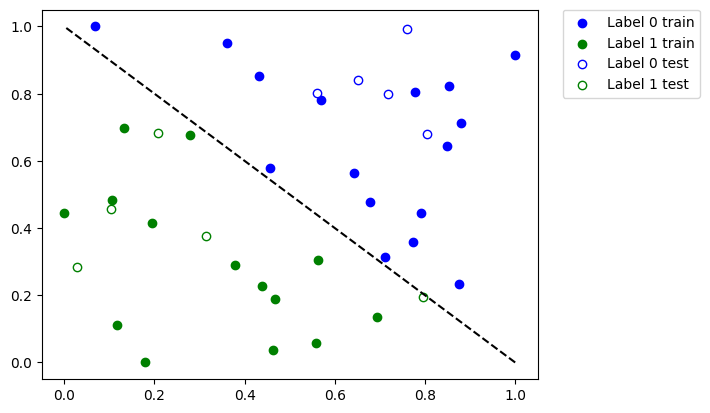

In [7]:
# Now PLOT - COPIED AND PASTED from:
# https://github.com/osbama/Phys710/blob/master/Lecture%203/Lecture3.ipynb

def plot_dataset():
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 0), 0],
        train_features[np.where(train_labels[:, 0] == 0), 1],
        marker="o",
        color="b",
        label="Label 0 train",
    )
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 1), 0],
        train_features[np.where(train_labels[:, 0] == 1), 1],
        marker="o",
        color="g",
        label="Label 1 train",
    )

    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 0), 0],
        test_features[np.where(test_labels[:, 0] == 0), 1],
        marker="o",
        facecolors="w",
        edgecolors="b",
        label="Label 0 test",
    )
    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 1), 0],
        test_features[np.where(test_labels[:, 0] == 1), 1],
        marker="o",
        facecolors="w",
        edgecolors="g",
        label="Label 1 test",
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.plot([1, 0], [0, 1], "--", color="black")


plot_dataset()
plt.show()

# since the random seed is specified, the garphs are equal with the soruce code

# Train a model and save it 

In [8]:
# We train our model in 20 iterations
maxiter = 20


* Create an empty array to store values from objective function
* We re-use a callback function from the Neural Network Classifier & Regressor tutorial to plot iteration versus objective function value with some minor tweaks to plot objective values at each step.

In [9]:
objective_values = []

In [10]:
# Plot function is COPIED 
# callback function that draws a live plot when the .fit() method is called
def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")

    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]

    stage2_len = np.max((0, len(objective_values) - maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len - 1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]

    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()


plt.rcParams["figure.figsize"] = (12, 6)


* Train VQC model with a COBYLA
* Evaluate performance of the model to see how well its trained
* SAVE THIS MODEL FOR A FILE
* ON A SECOND STEP WE LOAD THIS MODEL AND RE-USE


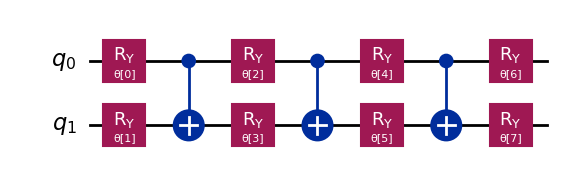

In [18]:
# Construct ansatz
maxiter = 20

original_optimizer = COBYLA(maxiter=20)

ansatz = RealAmplitudes(num_features)
initial_point = np.asarray([0.4]*ansatz.num_parameters)
decomposed = ansatz.decompose()
decomposed.draw(output="mpl")

In [12]:
#create a model and set a sampler to the first sampler

original_classifier = VQC(
    ansatz=ansatz, optimizer=original_optimizer, callback=callback_graph, sampler=sampler_teach
)

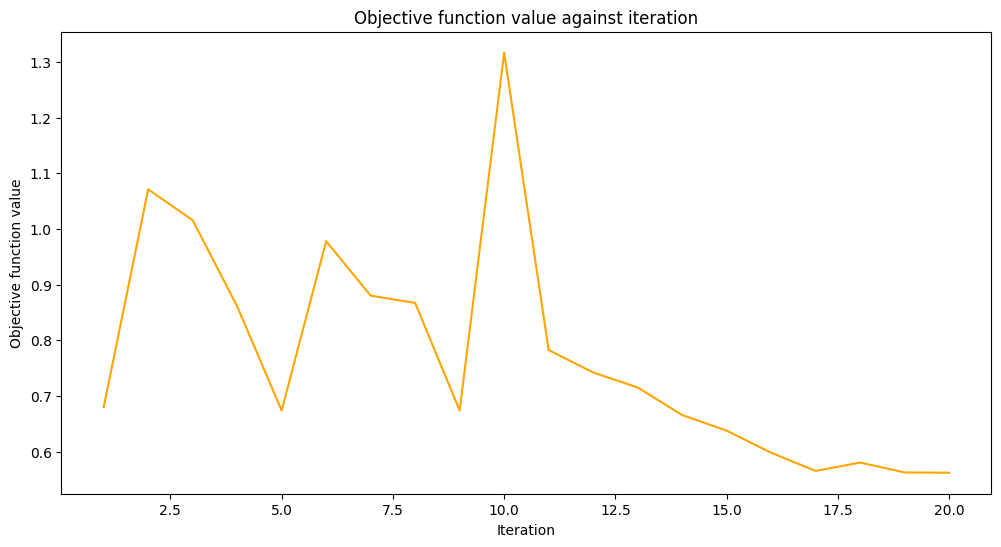

In [13]:
# NOW TRAIN THE MODEL
original_classifier.fit(train_features,train_labels)